<a href="https://colab.research.google.com/github/tyler-skaggs/Numerical-Analysis/blob/main/pinns_Wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Packages and setup

In [131]:
import sys

sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.integrate as integrate
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings
import time

warnings.filterwarnings('ignore')
np.random.seed(1324)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using CUDA


The Neural Network

In [262]:
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # parameters
        self.depth = len(layers)-1

        # set up layer order dict
        self.activation = torch.nn.Tanh

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        # deploy Layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

# The physics-guided nerual network
class PhysicsInformedNN():
    def __init__(self, X_IC_init, X_BC_initL, X_BC_initR,  X_f, layers, lb, ub, nu = 0.01/np.pi):
        # Boundary Conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)

        # data
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)

        self.x_IC = torch.tensor(X_IC_init[:, 0:1], requires_grad=True).float().to(device)
        self.t_IC = torch.tensor(X_IC_init[:, 1:2], requires_grad=True).float().to(device)

        self.x_BCL = torch.tensor(X_BC_initL[:, 0:1], requires_grad=True).float().to(device)
        self.t_BCL = torch.tensor(X_BC_initL[:, 1:2], requires_grad=True).float().to(device)
        self.x_BCR = torch.tensor(X_BC_initR[:, 0:1], requires_grad=True).float().to(device)
        self.t_BCR = torch.tensor(X_BC_initR[:, 1:2], requires_grad=True).float().to(device)

        self.u_IC = torch.tensor(X_IC_init[:, 2:3]).float().to(device)

        self.layers = layers
        self.nu = nu

        # Deep Neural Networks
        self.dnn = DNN(layers).to(device)

        # optimizer: using the same settings
        self.optimizer = torch.optim.Adam(self.dnn.parameters())

    def net_u(self, x, t):
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

    def net_u_t(self, x, t):
        u = self.net_u(x, t)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u))[0]
        return u_t

    def net_f(self, x, t):
        """ The pytorch autograd for calculating residual """
        u = self.net_u(x, t)

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_tt = torch.autograd.grad(
            u_t, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        f = u_xx - 1/4 * u_tt
        return f

    def loss_func(self):
        omega = [2, 10, 5]

        u_BC_pred_left = self.net_u(self.x_BCL, self.t_BCL)
        u_BC_pred_right = self.net_u(self.x_BCR, self.t_BCR)
        u_IC_pred = self.net_u(self.x_IC, self.t_IC)
        u_IC_Ppred = self.net_u_t(self.x_IC, self.t_IC)
        f_pred = self.net_f(self.x_f, self.t_f)

        loss_BC = torch.nn.MSELoss()(u_BC_pred_left, u_BC_pred_right)
        loss_IC = torch.nn.MSELoss()(u_IC_pred, self.u_IC) + torch.mean(u_IC_Ppred**2)

        loss_PDE = torch.mean(f_pred ** 2)

        loss = omega[0]*loss_PDE + omega[1] * loss_IC + omega[2] * loss_BC

        return loss, loss_PDE, loss_IC, loss_BC

    def train(self, epochs):
        loss_hist = np.array([0,0,0,0])
        for epoch in range(epochs):
            # Zero Gradients
            self.optimizer.zero_grad()

            # Compute Loss and Gradients
            loss, loss_PDE, loss_IC, loss_BC = self.loss_func()
            loss.backward()

            # Adjust Learning Weights
            self.optimizer.step()

            if epoch % 100 == 0:
                print(
                    'Epoch %d | Loss: %.5e, L_PDE: %.5e, L_IC: %.5e, L_BC: %.5e' % (
                        epoch,
                        loss.item(),
                        loss_PDE.item(),
                        loss_IC.item(),
                        loss_BC.item()
                    )
                )
            loss_hist = np.vstack((loss_hist, np.array(([
                loss.detach().cpu().numpy(),
                loss_PDE.detach().cpu().numpy(),
                loss_IC.detach().cpu().numpy(),
                loss_BC.detach().cpu().numpy()
            ]))))

        return np.delete(loss_hist, (0), axis=0)

    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()

        return u, f

Test Functions

In [276]:
def init_wave(x):
  L = 10
  n = 3
  return np.power(np.sin(np.pi/2 * x), 1)

def init_wave_prime(x):
  return np.zeros(len(x))

analytic_OffOn = 1
def analytic_Sol(x,t):
    v = 2

    return 1/2 * init_wave(x - v * t) + 1/2 * init_wave( x + v * t)


Hyperparametres and Training Data

In [275]:
Nx = 320
Nt = 160
N_f = 3000

layers = [2, 20, 20 ,20, 20, 20, 1]

lb = 0
ub = 2
lb_uval = 0
ub_uval = 0

plot_low = -0.2
plot_high = 1.1

# (x, t = 0)
x = (ub - lb) * np.random.random_sample(Nx) + lb
X_IC = np.vstack((x, np.zeros(len(x)), init_wave(x))).T

# Lower x Bound
t = np.random.random_sample(Nt)
u_lb = lb_uval * np.ones(Nt)
init_lb = np.vstack((lb * np.ones(Nt), t, u_lb)).T

# Upper x Bound
#t = np.random.random_sample(Nt)
u_ub = ub_uval * np.ones(Nt)
init_ub = np.vstack((ub * np.ones(Nt), t, u_ub)).T

X_BC = np.vstack((init_lb, init_ub))

# Random N_f data to train on
X_training = np.random.random_sample((N_f, 2))
X_training[:, 0] = (ub-lb) * X_training[:, 0] + lb
x = X_training[:, 0]
t = X_training[:, 1]
X_training = np.vstack((X_training, X_IC[:, 0:2], X_BC[:, 0:2]))

Training

In [281]:
epochs = 15000
start_time = time.time()

model = PhysicsInformedNN(X_IC, init_lb, init_ub, X_training, layers, lb, ub)
loss_history = model.train(epochs)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Executation Time: {elapsed_time:.6f} seconds")


Epoch 0 | Loss: 1.40265e+00, L_PDE: 3.04399e-05, L_IC: 1.40010e-01, L_BC: 4.97858e-04
Epoch 100 | Loss: 1.00631e+00, L_PDE: 2.96510e-03, L_IC: 1.00028e-01, L_BC: 2.06381e-05
Epoch 200 | Loss: 6.74370e+00, L_PDE: 3.34705e-02, L_IC: 6.60466e-01, L_BC: 1.44181e-02
Epoch 300 | Loss: 3.35425e+01, L_PDE: 2.24702e-02, L_IC: 3.33663e+00, L_BC: 2.62534e-02
Epoch 400 | Loss: 4.04095e+01, L_PDE: 1.06836e-02, L_IC: 4.02985e+00, L_BC: 1.79369e-02
Epoch 500 | Loss: 4.67379e+01, L_PDE: 6.04212e-03, L_IC: 4.66362e+00, L_BC: 1.79139e-02
Epoch 600 | Loss: 5.51531e+01, L_PDE: 4.99328e-03, L_IC: 5.50547e+00, L_BC: 1.76845e-02
Epoch 700 | Loss: 7.54052e+01, L_PDE: 4.39676e-03, L_IC: 7.53153e+00, L_BC: 1.62244e-02
Epoch 800 | Loss: 1.57741e+02, L_PDE: 3.54743e-03, L_IC: 1.57708e+01, L_BC: 5.18001e-03
Epoch 900 | Loss: 2.03604e+02, L_PDE: 1.99873e-03, L_IC: 2.03597e+01, L_BC: 6.27271e-04
Epoch 1000 | Loss: 2.07942e+02, L_PDE: 9.85338e-04, L_IC: 2.07939e+01, L_BC: 2.52010e-04
Epoch 1100 | Loss: 2.03527e+02, L

Make Predictions

In [282]:
x_pred = np.array([np.linspace(lb, ub, 100)]).T
t_pred = np.array([np.linspace(0,1, 101)]).T
X, T = np.meshgrid(x_pred,t_pred)

X_pred = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

u_pred, f_pred = model.predict(X_pred)
U_pred = griddata(X_pred, u_pred.flatten(), (X, T), method = 'cubic')

Loss Map

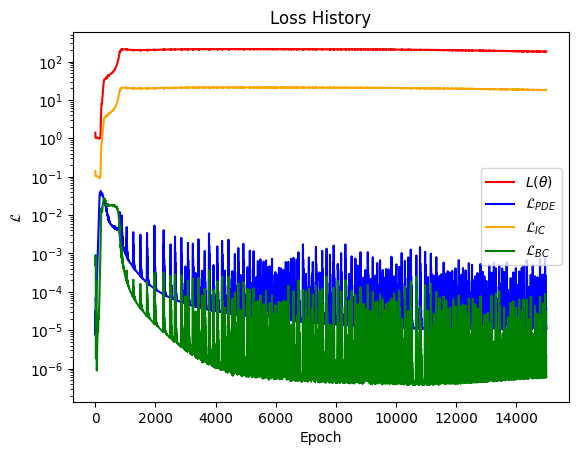

In [283]:
plt.plot(range(1,epochs+1), loss_history[:,0], color='red', label=r"$L(\theta)$")
plt.plot(range(1,epochs+1), loss_history[:,1], color='blue', label=r"$\mathcal{L}_{PDE}$")
plt.plot(range(1,epochs+1), loss_history[:,2], color='orange', label=r"$\mathcal{L}_{IC}$")
plt.plot(range(1,epochs+1), loss_history[:,3], color='green', label=r"$\mathcal{L}_{BC}$")
plt.ylabel(r"$\mathcal{L}$")
plt.xlabel("Epoch")
plt.legend()
plt.yscale('log')
plt.title("Loss History")
plt.show()

Heat Map & Slices

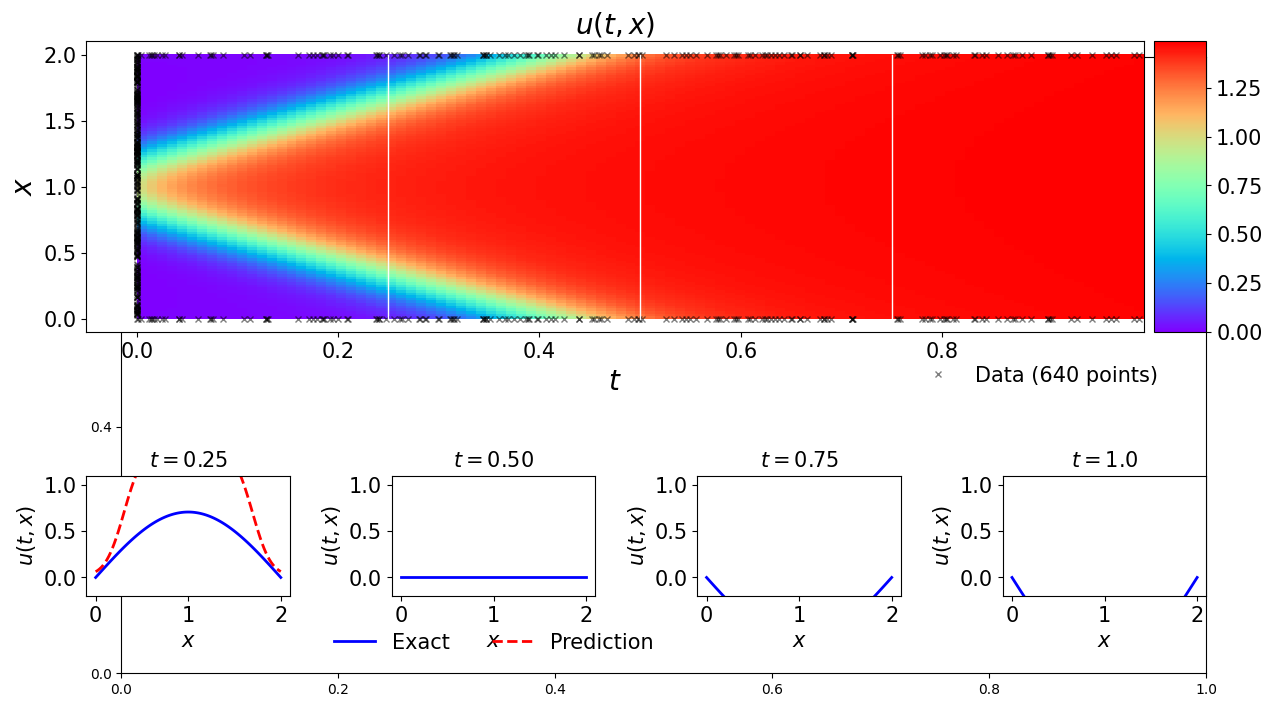

In [284]:
####### HEAT MAP AND SLICES ##################
""" The aesthetic setting has changed. """
dx = x_pred[1]-x_pred[0]

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
gs1 = gridspec.GridSpec(2, 4)
gs1.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.5)

# HEAT MAP
ax = plt.subplot(gs1[0, :])
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

X_initial = np.vstack((X_IC, X_BC))
ax.plot(
    X_initial[:,1],
    X_initial[:,0],
    'kx', label = 'Data (%d points)' % (X_initial[:, 2].shape[0]),
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(0.25*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(0.5*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(0.75*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

# Slices
ax = plt.subplot(gs1[1, 0])
if analytic_OffOn:
    ax.plot(x_pred, analytic_Sol(x_pred, t = 0.25), 'b-', linewidth = 2, label = 'Exact')
    #error = pow(dx * sum(pow((analytic_Sol(x_pred, t=0.25) - U_pred[25, :]), 2)), 1 / 2)
    #text = plt.text(-1, 0, f"Error = %.5f" % error)
ax.plot(x_pred, U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([lb-0.1, ub+0.1])
ax.set_ylim([plot_low, plot_high])



for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[1, 1])
if analytic_OffOn:
    ax.plot(x_pred, analytic_Sol(x_pred, t = 0.5), 'b-', linewidth = 2, label = 'Exact')
    #error = pow(dx * sum(pow((analytic_Sol(x_pred, t=0.5) - U_pred[50, :]), 2)), 1 / 2)
    #text = plt.text(-1, 0, f"Error = %.5f" % error)
ax.plot(x_pred, U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([lb-0.1, ub+0.1])
ax.set_ylim([plot_low, plot_high])
ax.set_title('$t = 0.50$', fontsize = 15)



ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=5,
    frameon=False,
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[1, 2])
if analytic_OffOn:
    ax.plot(x_pred, analytic_Sol(x_pred, t = 0.75), 'b-', linewidth = 2, label = 'Exact')
    #error = pow(dx * sum(pow((analytic_Sol(x_pred, t=0.75) - U_pred[75, :]), 2)), 1 / 2)
    #text = plt.text(-1, 0, f"Error = %.5f" % error)
ax.plot(x_pred,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([lb-0.1, ub+0.1])
ax.set_ylim([plot_low, plot_high])
ax.set_title('$t = 0.75$', fontsize = 15)



for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[1, 3])
if analytic_OffOn:
    ax.plot(x_pred, analytic_Sol(x_pred, t = 1), 'b-', linewidth = 2, label = 'Exact')
    #error = pow(dx * sum(pow((analytic_Sol(x_pred, t=1) - U_pred[100, :]), 2)), 1 / 2)
    #text = plt.text(-1, 0, f"Error = %.5f" % error)
ax.plot(x_pred,U_pred[100,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([lb-0.1, ub+0.1])
ax.set_ylim([plot_low, plot_high])
ax.set_title('$t = 1.0$', fontsize = 15)



for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()